In [26]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np

In [27]:
audio_file = "./14/19020066_HoangHuuTung/c2.wav"

In [28]:
ipd.Audio(audio_file,autoplay=True)

In [29]:
# load audio files with librosa
signal, sr = librosa.load(audio_file)

In [30]:
print(sr)

22050


In [31]:
mfccs = librosa.feature.mfcc(y=signal, n_mfcc=13, sr=sr)

In [32]:
mfccs.shape

(13, 223)

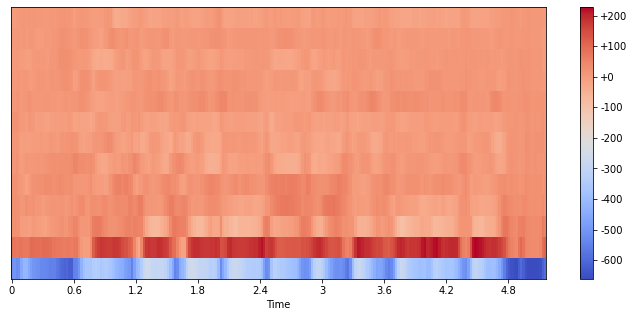

In [33]:
plt.figure(figsize=(12, 5))
librosa.display.specshow(mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

In [34]:
delta_mfccs = librosa.feature.delta(mfccs)

In [35]:
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

In [36]:
delta_mfccs.shape

(13, 223)

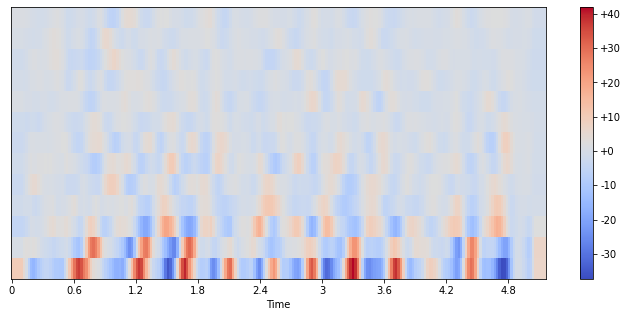

In [37]:
plt.figure(figsize=(12, 5))
librosa.display.specshow(delta_mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

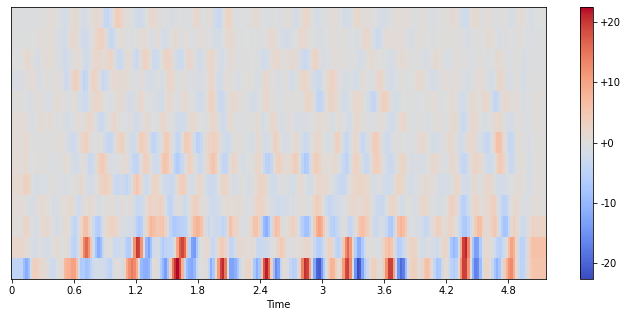

In [38]:
plt.figure(figsize=(12, 5))
librosa.display.specshow(delta2_mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

In [39]:
mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))

In [40]:
mfccs_features.shape

(39, 223)

In [41]:
class_names = ['xuong', 'len', 'phai', 'trai', 'nhay', 'ban', 'a', 'b', 'sil']

In [42]:
for i in class_names:
    !mkdir $i

A subdirectory or file xuong already exists.
A subdirectory or file len already exists.
A subdirectory or file phai already exists.
A subdirectory or file trai already exists.
A subdirectory or file nhay already exists.
A subdirectory or file ban already exists.
A subdirectory or file a already exists.
A subdirectory or file b already exists.
A subdirectory or file sil already exists.


In [46]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


### Hàm cắt file wav

In [48]:
input_path = './14/'
output_path = './'
from pydub import AudioSegment
def split_wav(t1,t2,name,dir_name,name_export):
    t1 = t1 * 1000 #Works in milliseconds
    t2 = t2 * 1000
    name = input_path + dir_name +'/'+ name
    newAudio = AudioSegment.from_wav(name)
    newAudio = newAudio[t1:t2]
    name_export = output_path + name_export +".wav"
    newAudio.export(name_export, format="wav")

# Tiền xử lý dữ liệu
Dữ liệu đang ở dạng 1 file wav chứa rất nhiều từ, chúng ta cần tách file wav thành nhiều file nhỏ và mỗi file chỉ có 1 từ duy nhất 
Hàm này sẽ tách toàn bộ âm thanh chứa trong data, chia nó về các folder data train với tên folder là các nhãn, trong các folder này chứa nhiều file wav, mỗi file wav chỉ chứa duy nhất tiếng của nhãn cần train

In [49]:
count = 0
import os
import pandas as pd
for name_dir in os.listdir(os.path.join(input_path)):
    for i in os.listdir(os.path.join(input_path, name_dir)):
        if i.endswith('.wav'):
            path = i[:-3]
            path_txt = path + 'txt'
            if(os.path.exists(os.path.join(input_path,name_dir,path_txt))):
                df = pd.read_csv(os.path.join(input_path,name_dir,path_txt), sep="\t", header=None)
                for index, row in df.iterrows():
                    count+=1
                    isdir = os.path.isdir(path)
                    if(row[2]=='sli'):
                        row[2] = 'sil'
                    row[2]=row[2].replace(" ", "")
                    row[2]=row[2].lower()
                    if(row[2]=='pha'):
                        row[2] = 'phai'

                    if row[2]=='suong':
                        row[2] = 'xuong'
                    if row[2]=='xuon':
                        row[2] = 'xuong'
                    name_export = row[2] +'/'+ str(count)
                    split_wav(row[0],row[1],i,name_dir,name_export)
                

In [50]:
print(count)

4584


In [ ]:
# import time
# for name_dir in os.listdir(os.path.join(output_path)):
#     if name_dir == 'sil' or name_dir =='__notebook_source__.ipynb':
#         continue
#     for i in os.listdir(os.path.join(output_path, name_dir)):
#         if i.endswith('.wav'):
#             ipd.display(ipd.Audio(os.path.join(output_path,name_dir,i),autoplay=True))
#             time.sleep(1)
    

In [82]:
# HMM state cho từng từ
states = [9, 9, 9, 9, 9, 9, 9, 9, 9]

In [51]:
import librosa
import numpy as np
import os
import math
from sklearn.cluster import KMeans
import hmmlearn.hmm

def get_mfcc(file_path):
    y, sr = librosa.load(file_path) # read .wav file
#     hop_length = math.floor(sr*0.010) # 10ms hop
    hop_length = 256
#     win_length = math.floor(sr*0.025) # 25ms frame
    win_length = 512
    # mfcc is 12 x T matrix
    mfcc = librosa.feature.mfcc(
        y=y, sr=sr, n_mfcc=13, n_fft=1024,
        hop_length=hop_length, win_length=win_length)
    # substract mean from mfcc --> normalize mfcc
#     mfcc = mfcc - np.mean(mfcc, axis=1).reshape((-1,1)) 
    mfcc = np.subtract(mfcc,np.mean(mfcc))
    # delta feature 1st order and 2nd order
    delta1 = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    # X is 39 x T
    X = np.concatenate([mfcc, delta1, delta2], axis=0) # O^r
    # return T x 39 (transpose of X)
    return X.T # hmmlearn use T x N matrix

In [52]:
a = get_mfcc('./14/19020066_HoangHuuTung/c15-c23.wav')
print(type(a.shape))

<class 'tuple'>


In [69]:
#clean file

all_data = {}
all_labels = {}
for cname in class_names:
    file_paths = [os.path.join("./", cname, i) for i in os.listdir(os.path.join('./', cname)) if i.endswith('.wav')]
    data = []
    for file_path in file_paths:
        try:
            data.append(get_mfcc(file_path))
        except:
            print(file_path)
            os.remove(file_path) 
    
    all_data[cname] = data
    all_labels[cname] = [class_names.index(cname) for i in range(len(file_paths))]

In [80]:
from sklearn.model_selection import train_test_split

X = {'train': {}, 'test': {}}
y = {'train': {}, 'test': {}}
for cname in class_names:
    x_train, x_test, _, y_test = train_test_split(
        all_data[cname], all_labels[cname], 
        test_size = 0.33, 
        random_state=42
    )
    X['train'][cname] = x_train
    X['test'][cname] = x_test
    y['test'][cname] = y_test

In [77]:
for cname in class_names:
    print(cname,len(X['train'][cname]), len(X['test'][cname]), len(y['test'][cname]))

xuong 318 158 158
len 335 166 166
phai 306 152 152
trai 340 168 168
nhay 365 181 181
ban 317 157 157
a 326 161 161
b 361 179 179
sil 394 195 195


In [83]:
import hmmlearn.hmm as hmm

model = {}
for idx, cname in enumerate(class_names):
    start_prob = np.full(states[idx], 0.0)
    start_prob[0] = 1.0
    trans_matrix = np.full((states[idx], states[idx]), 0.0)
    p = 0.5
    np.fill_diagonal(trans_matrix, p)
    np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
    trans_matrix[-1, -1] = 1.0
    
    #trans matrix
    print(cname)
    print(trans_matrix) 

    model[cname] = hmm.GaussianHMM(
        n_components=states[idx], 
        verbose=True, 
        n_iter=300, 
        startprob_prior=start_prob, 
        transmat_prior=trans_matrix,
        params='stmc',
        init_params='mc',
        random_state=42
    )

    model[cname].fit(X=np.vstack(X['train'][cname]), lengths=[x.shape[0] for x in X['train'][cname]])

xuong
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -1932703.4513             +nan
         2    -1850949.1610      +81754.2903
         3    -1840266.4321      +10682.7288
         4    -1836768.5984       +3497.8337
         5    -1834661.0061       +2107.5923
         6    -1832759.8538       +1901.1523
         7    -1830962.9068       +1796.9470
         8    -1829596.5375       +1366.3693
         9    -1828606.4799        +990.0576
        10    -1827112.6444       +1493.8355
        11    -1824413.2312       +2699.4132
        12    -1821828.1376       +2585.0936
        13    -1819881.7789       +1946.3588
        14    -1818636.6699       +1245.1090
        15    -1817711.0204        +925.6495
        16    -1817396.3818        +314.6386
        17    -1817287.8423        +108.5395
        18    -1817229.7442         +58.0981
        19    -1817201.7457         +27.9985
        20    -1817185.1370         +16.6086
        21    -1817172.4437         +12.6933
        22    -1817164.1346          +8.3091
        23

len
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -1801123.3951             +nan
         2    -1707116.2334      +94007.1617
         3    -1686122.8607      +20993.3727
         4    -1676407.4184       +9715.4423
         5    -1672450.6817       +3956.7367
         6    -1671611.1524        +839.5293
         7    -1671314.8686        +296.2838
         8    -1671148.2888        +166.5798
         9    -1671042.6464        +105.6424
        10    -1670972.9920         +69.6544
        11    -1670920.5655         +52.4265
        12    -1670855.7651         +64.8004
        13    -1670750.3474        +105.4177
        14    -1670613.9899        +136.3575
        15    -1670464.4616        +149.5283
        16    -1670279.0192        +185.4424
        17    -1670066.4323        +212.5870
        18    -1669820.5882        +245.8441
        19    -1669502.4334        +318.1547
        20    -1669109.1067        +393.3267
        21    -1668828.2419        +280.8649
        22    -1668653.5360        +174.7059
        23

phai
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -1607575.4294             +nan
         2    -1536624.0938      +70951.3356
         3    -1526688.5655       +9935.5283
         4    -1521108.0616       +5580.5038
         5    -1515518.0228       +5590.0388
         6    -1512760.9222       +2757.1006
         7    -1511494.3157       +1266.6065
         8    -1510772.0927        +722.2230
         9    -1510500.8388        +271.2539
        10    -1510275.4759        +225.3628
        11    -1510086.1421        +189.3339
        12    -1509921.4036        +164.7384
        13    -1509787.5676        +133.8360
        14    -1509690.5073         +97.0603
        15    -1509611.2268         +79.2805
        16    -1509539.8455         +71.3813
        17    -1509477.6857         +62.1598
        18    -1509440.3361         +37.3496
        19    -1509416.8493         +23.4868
        20    -1509397.7612         +19.0881
        21    -1509377.2207         +20.5405
        22    -1509356.3446         +20.8761
        23

trai
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -1869647.0422             +nan
         2    -1777804.6312      +91842.4111
         3    -1766356.5266      +11448.1046
         4    -1758075.1695       +8281.3571
         5    -1750103.7419       +7971.4276
         6    -1743947.9337       +6155.8082
         7    -1739764.1201       +4183.8136
         8    -1737822.3951       +1941.7250
         9    -1736940.5401        +881.8550
        10    -1736480.5421        +459.9980
        11    -1736231.0999        +249.4422
        12    -1736094.2793        +136.8206
        13    -1736008.9526         +85.3267
        14    -1735966.3715         +42.5812
        15    -1735958.7184          +7.6531
        16    -1735944.8513         +13.8671
        17    -1735936.1328          +8.7185
        18    -1735929.0866          +7.0462
        19    -1735923.9824          +5.1042
        20    -1735920.8277          +3.1547
        21    -1735920.5312          +0.2965
        22    -1735918.5147          +2.0166
        23

nhay
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -1924482.8515             +nan
         2    -1840410.1657      +84072.6858
         3    -1820973.6488      +19436.5169
         4    -1810843.1430      +10130.5058
         5    -1806769.2060       +4073.9370
         6    -1804608.6174       +2160.5886
         7    -1803635.5937        +973.0237
         8    -1803099.1068        +536.4869
         9    -1802823.5410        +275.5658
        10    -1802691.8574        +131.6836
        11    -1802634.6493         +57.2081
        12    -1802599.9461         +34.7032
        13    -1802580.2221         +19.7240
        14    -1802571.2534          +8.9688
        15    -1802567.3985          +3.8548
        16    -1802565.0597          +2.3388
        17    -1802563.3355          +1.7243
        18    -1802562.0629          +1.2725
        19    -1802561.1835          +0.8795
        20    -1802560.5972          +0.5863
        21    -1802560.2057          +0.3915
        22    -1802559.9347          +0.2710
        23

ban
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -1587595.7449             +nan
         2    -1507867.0117      +79728.7333
         3    -1489547.0136      +18319.9980
         4    -1485575.5822       +3971.4314
         5    -1481620.0955       +3955.4867
         6    -1479387.1726       +2232.9229
         7    -1478530.7768        +856.3958
         8    -1477906.7311        +624.0457
         9    -1477296.4896        +610.2414
        10    -1476409.2707        +887.2189
        11    -1475511.9236        +897.3472
        12    -1475356.4025        +155.5211
        13    -1475304.1335         +52.2689
        14    -1475277.7768         +26.3567
        15    -1475251.7017         +26.0751
        16    -1475217.7641         +33.9376
        17    -1475187.9979         +29.7662
        18    -1475153.9106         +34.0873
        19    -1475118.4560         +35.4546
        20    -1475092.6956         +25.7604
        21    -1475076.6913         +16.0043
        22    -1475063.3222         +13.3691
        23

a
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -1643526.5350             +nan
         2    -1527703.5402     +115822.9948
         3    -1490862.7348      +36840.8054
         4    -1486550.6166       +4312.1181
         5    -1485171.0542       +1379.5624
         6    -1484312.5254        +858.5289
         7    -1483628.5933        +683.9321
         8    -1483094.0739        +534.5194
         9    -1482826.1610        +267.9129
        10    -1482691.4341        +134.7269
        11    -1482637.7559         +53.6782
        12    -1482612.2279         +25.5280
        13    -1482600.4423         +11.7857
        14    -1482596.1810          +4.2613
        15    -1482601.9086          -5.7276


b
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -1942981.9076             +nan
         2    -1809936.8997     +133045.0079
         3    -1780026.0707      +29910.8290
         4    -1761357.7299      +18668.3407
         5    -1754098.9240       +7258.8059
         6    -1749786.9628       +4311.9612
         7    -1746254.6881       +3532.2747
         8    -1743579.0726       +2675.6155
         9    -1742363.0659       +1216.0067
        10    -1741867.4772        +495.5887
        11    -1741690.7815        +176.6957
        12    -1741601.3970         +89.3845
        13    -1741545.3242         +56.0728
        14    -1741517.3596         +27.9646
        15    -1741502.0192         +15.3404
        16    -1741493.8985          +8.1207
        17    -1741488.8540          +5.0445
        18    -1741485.1886          +3.6654
        19    -1741481.8721          +3.3165
        20    -1741479.5845          +2.2876
        21    -1741478.5074          +1.0771
        22    -1741478.0345          +0.4729
        23

sil
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -1904775.8699             +nan
         2    -1783207.9606     +121567.9093
         3    -1759426.9681      +23780.9925
         4    -1753102.3293       +6324.6388
         5    -1747930.5158       +5171.8134
         6    -1745390.1100       +2540.4058
         7    -1744422.3031        +967.8069
         8    -1743974.3135        +447.9896
         9    -1743668.4527        +305.8608
        10    -1743372.0220        +296.4307
        11    -1743016.3068        +355.7152
        12    -1742735.4687        +280.8381
        13    -1742520.5556        +214.9131
        14    -1742327.1207        +193.4349
        15    -1742131.7920        +195.3287
        16    -1741924.7986        +206.9934
        17    -1741668.7990        +255.9996
        18    -1741476.1981        +192.6008
        19    -1741332.0341        +144.1641
        20    -1741246.3107         +85.7234
        21    -1741175.4647         +70.8460
        22    -1741107.6194         +67.8453
        23

In [ ]:
import pickle
!mkdir models_train
# save model
for cname in class_names:
    name = f'models_train/model_{cname}.pkl'
    with open(name, 'wb') as file: 
        pickle.dump(model[cname], file)

In [ ]:
import pickle, os
import numpy as np

from sklearn.metrics import classification_report

In [ ]:
y_true = []
y_pred = []
for cname in class_names:
    for mfcc, target in zip(X['test'][cname], y['test'][cname]):
        scores = [model[cname].score(mfcc) for cname in class_names]
        pred = np.argmax(scores)
        y_pred.append(pred)
        y_true.append(target)
    print((np.array(y_true) == np.array(y_pred)).sum()/len(y_true))
print(y_true)
print(y_pred)


1.0
0.9876543209876543
0.9831932773109243
0.9720496894409938
0.9733333333333334
0.9765784114052953
0.9781277340332458
0.9795763993948563
0.978246539222149
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       xuong       0.99      1.00      1.00       158
         len       0.99      0.98      0.98       166
        phai       0.92      0.97      0.95       152
        trai       0.98      0.94      0.96       168
        nhay       0.99      0.98      0.98       181
         ban       0.98      0.99      0.99       157
           a       0.96      0.99      0.97       161
           b       0.99      0.99      0.99       179
         sil       1.00      0.97      0.98       195

    accuracy                           0.98      1517
   macro avg       0.98      0.98      0.98      1517
weighted avg       0.98      0.98      0.98      1517



In [ ]:
#loadmodels
import pickle

model_train = {}
for key in class_names:
    name = f"models_train/model_{key}.pkl"
    with open(name, 'rb') as file:
        model_train[key] = pickle.load(file)

In [ ]:
print(model_train)

{'xuong': GaussianHMM(init_params='mc', n_components=9, n_iter=300, random_state=42,
            startprob_prior=array([1., 0., 0., 0., 0., 0., 0., 0., 0.]),
            transmat_prior=array([[0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]]),
            verbose=True), 'len': GaussianHMM(init_params='mc', n_components=9, n_iter=300, random_state=42,
            startprob_prior=array([1., 0., 0., 0., 0., 0., 0., 0., 0.]),
            transmat_prior=array([[0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.

In [ ]:
!zip -r models.zip models_train

  adding: models_train/ (stored 0%)
  adding: models_train/model_sil.pkl (deflated 19%)
  adding: models_train/model_ban.pkl (deflated 20%)
  adding: models_train/model_b.pkl (deflated 21%)
  adding: models_train/model_a.pkl (deflated 19%)
  adding: models_train/model_len.pkl (deflated 24%)
  adding: models_train/model_nhay.pkl (deflated 19%)
  adding: models_train/model_trai.pkl (deflated 38%)
  adding: models_train/model_phai.pkl (deflated 21%)
  adding: models_train/model_xuong.pkl (deflated 24%)
